<a href="https://colab.research.google.com/github/chineidu/NLP-Tutorial/blob/main/notebook/06_Transformers/NLP-With-Transformers/02a-NER-football.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers accelerate datasets \
  seqeval mlxtend watermark rich pyarrow==14.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.3.1 which is incompatible.


In [ ]:
# !pip install --upgrade -q pyarrow datasets

In [2]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,mlxtend,transformers --conda

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.26.4
pandas      : 2.1.4
polars      : 0.20.2
mlxtend     : 0.23.1
transformers: 4.42.4

conda environment: n/a



In [3]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")


# # Black code formatter (Optional)
# %load_ext lab_black

# # auto reload imports
# %load_ext autoreload
# %autoreload 2

### Load Data

In [ ]:
# fp: str = "../../../data/ner_data.jsonl"

# with open(fp, "r") as f:
#     json_data = [json.loads(line) for line in f]

# print(len(json_data))

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk
from datasets.features.features import ClassLabel, Sequence

# data: DatasetDict = load_dataset("ontonotes/conll2012_ontonotesv5", "english_v4")
# data.save_to_disk("../../../data/conll2012_ontonotesv5")

# fp: str = "../../../data/conll2012_ontonotesv5"
fp: str = "/content/drive/MyDrive/My doc/Deep Learning/Data/conll2012_ontonotesv5"
fp: str = "/content/drive/MyDrive/Data/conll2012_ontonotesv5"

ds_dict_original: DatasetDict = load_from_disk(dataset_path=fp)
ds_dict_original

DatasetDict({
    train: Dataset({
        features: ['document_id', 'sentences'],
        num_rows: 1940
    })
    validation: Dataset({
        features: ['document_id', 'sentences'],
        num_rows: 222
    })
    test: Dataset({
        features: ['document_id', 'sentences'],
        num_rows: 222
    })
})

In [7]:
ds_dict_original["train"].features["sentences"][0]

{'part_id': Value(dtype='int32', id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['XX', '``', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'ADD', 'AFX', 'CC', 'CD', 'DT', 'EX', 'FW', 'HYPH', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NFP', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'parse_tree': Value(dtype='string', id=None),
 'predicate_lemmas': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'predicate_framenet_ids': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'word_senses': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None),
 'speaker': Value(dtype='string', id=None),
 'named_entities': Sequence(feature=ClassLabel(names=['O', 'B-PERSON', 'I-PERSON', 'B-NORP', 'I-NORP', 'B-FA

In [8]:
tags: ClassLabel = ds_dict_original["train"].features["sentences"][0]["named_entities"].feature
print(tags)

ClassLabel(names=['O', 'B-PERSON', 'I-PERSON', 'B-NORP', 'I-NORP', 'B-FAC', 'I-FAC', 'B-ORG', 'I-ORG', 'B-GPE', 'I-GPE', 'B-LOC', 'I-LOC', 'B-PRODUCT', 'I-PRODUCT', 'B-DATE', 'I-DATE', 'B-TIME', 'I-TIME', 'B-PERCENT', 'I-PERCENT', 'B-MONEY', 'I-MONEY', 'B-QUANTITY', 'I-QUANTITY', 'B-ORDINAL', 'I-ORDINAL', 'B-CARDINAL', 'I-CARDINAL', 'B-EVENT', 'I-EVENT', 'B-WORK_OF_ART', 'I-WORK_OF_ART', 'B-LAW', 'I-LAW', 'B-LANGUAGE', 'I-LANGUAGE'], id=None)


In [9]:
# index2tag: dict[int, str] = {tags.str2int(tag): tag for tag in tags.names}
# tag2index: dict[str, int] = {tag: tags.str2int(tag) for tag in tags.names}

# print(index2tag)

In [10]:
original_index2tag: dict[int, str] ={
    0: "O",
    1: "B-PERSON",
    2: "I-PERSON",
    7: "B-ORG",
    8: "I-ORG",
    9: "B-GPE",
    10: "I-GPE",
    11: "B-LOC",
    12: "I-LOC",
    15: "B-DATE",
    16: "I-DATE",
    17: "B-TIME",
    18: "I-TIME",
    21: "B-MONEY",
    22: "I-MONEY",
}


index2tag: dict[int, str] = {
    0: "O",
    1: "B-PERSON",
    2: "I-PERSON",
    3: "B-ORG",
    4: "I-ORG",
    5: "B-GPE",
    6: "I-GPE",
    7: "B-LOC",
    8: "I-LOC",
    9: "B-DATE",
    10: "I-DATE",
    11: "B-TIME",
    12: "I-TIME",
    13: "B-MONEY",
    14: "I-MONEY",
}
tag2index: dict[str, int] = {tag:idx for idx, tag in index2tag.items()}
tag2index

{'O': 0,
 'B-PERSON': 1,
 'I-PERSON': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-GPE': 5,
 'I-GPE': 6,
 'B-LOC': 7,
 'I-LOC': 8,
 'B-DATE': 9,
 'I-DATE': 10,
 'B-TIME': 11,
 'I-TIME': 12,
 'B-MONEY': 13,
 'I-MONEY': 14}

### Comment

- Drop irrelevant columns

In [11]:
def extract_tokens_and_labels(example: dict[str, Any]) -> dict[str, Any]:
    default: int = 0

    tokens = example["sentences"][0]["words"]
    named_entities: list[int] = example["sentences"][0]["named_entities"]
    wanted_labels: list[str] = [
        l if l in original_index2tag.keys() else default for l in named_entities
    ]

    # Update the labels
    ner_labels: list[str] = [original_index2tag[l] for l in wanted_labels]
    labels: list[int] = [tag2index[l] for l in ner_labels]

    example["tokens"] = tokens
    example["labels"] = labels
    example["ner_labels"] = ner_labels

    return example


def check_all_labels_zero(example: dict[str, Any]) -> bool:
    """
    Check if all labels in the example are zero.

    Parameters
    ----------
    example : dict[str, Any]
        A dictionary containing a 'labels' key with a list of label values.

    Returns
    -------
    bool
        True if at least one label is non-zero, False if all labels are zero.

    """
    # Check if all labels are zero
    label_filter: list[bool] = [x == 0 for x in example["labels"]]
    return not all(label_filter)

In [12]:
# ClassLabel object
class_label = ClassLabel(num_classes=len(tag2index), names=list(tag2index.keys()))


# Create a copy
ds_dict: DatasetDict = ds_dict_original.copy()

for split in ds_dict.keys():
    # Extract tokens and drop irrelevant tags
    ds_dict[split] = ds_dict[split].map(extract_tokens_and_labels)
    ds_dict[split] = ds_dict[split].remove_columns(["document_id", "sentences"])
    ds_dict[split] = ds_dict[split].filter(check_all_labels_zero)
    # Update the 'labels' column to use ClassLabel
    ds_dict[split] = ds_dict[split].cast_column(
        column="labels", feature=Sequence(class_label)
    )

ds_dict

Map:   0%|          | 0/1940 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1940 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1461 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Filter:   0%|          | 0/222 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/174 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Filter:   0%|          | 0/222 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/179 [00:00<?, ? examples/s]

{'train': Dataset({
     features: ['tokens', 'labels', 'ner_labels'],
     num_rows: 1461
 }),
 'validation': Dataset({
     features: ['tokens', 'labels', 'ner_labels'],
     num_rows: 174
 }),
 'test': Dataset({
     features: ['tokens', 'labels', 'ner_labels'],
     num_rows: 179
 })}

In [13]:
ds_dict["train"][8] # 82, 3

{'tokens': ['In',
  'June',
  'of',
  '2004',
  ',',
  'the',
  'Shanxi',
  'Yongji',
  'Peasants',
  'Association',
  'was',
  'formally',
  'established',
  ';',
  'it',
  'now',
  'has',
  '3,800',
  'members',
  '.'],
 'labels': [0, 9, 10, 10, 0, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'ner_labels': ['O',
  'B-DATE',
  'I-DATE',
  'I-DATE',
  'O',
  'B-ORG',
  'I-ORG',
  'I-ORG',
  'I-ORG',
  'I-ORG',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']}

In [14]:
df: pl.DataFrame = ds_dict["train"].to_polars()
df = df.with_columns(token_length=pl.col("tokens").map_elements(lambda x: len(x)))
df.sample(n=10, seed=123).to_pandas()

,tokens,labels,ner_labels,token_length
0,"[Hey, ,, folks, in, Al, -, Qasim, ,, is, the, news, I, heard, true, ?]","[0, 0, 0, 0, 5, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0]","[O, O, O, O, B-GPE, I-GPE, I-GPE, O, O, O, O, O, O, O, O]",15
1,"[Israeli, -, Palestinian, peace, talks, have, ended, in, Egypt, with, a, statement, declaring, the, two, sides, closer, than, ever, to, a, final, agreement, .]","[0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[O, O, O, O, O, O, O, O, B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",24
2,"[French, consumer, prices, rose, 0.2, %, in, September, from, August, ,, according, to, provisional, estimates, by, the, National, Statistics, Institute, .]","[0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 0]","[O, O, O, O, O, O, O, B-DATE, O, B-DATE, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, I-ORG, O]",21
3,"[In, Michigan, ,, a, second, straight, night, and, into, this, morning, ,, hundreds, of, people, have, been, rioting, in, Benton, Harbor, .]","[0, 5, 0, 0, 0, 0, 11, 0, 0, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0]","[O, B-GPE, O, O, O, O, B-TIME, O, O, B-TIME, I-TIME, O, O, O, O, O, O, O, O, B-GPE, I-GPE, O]",22
4,"[Xinhua, News, Agency, ,, Guangzhou, ,, April, 16th, ,, by, reporter, Wenjian, Mou, and, Guangzhi, Ling]","[3, 4, 4, 0, 5, 0, 9, 10, 0, 0, 0, 1, 2, 0, 1, 2]","[B-ORG, I-ORG, I-ORG, O, B-GPE, O, B-DATE, I-DATE, O, O, O, B-PERSON, I-PERSON, O, B-PERSON, I-PERSON]",16
5,"[These, are, the, last, words, Abbie, Hoffman, ever, uttered, ,, more, or, less, ,, before, he, killed, himself, .]","[0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[O, O, O, O, O, B-PERSON, I-PERSON, O, O, O, O, O, O, O, O, O, O, O, O]",19
6,"[The, US, warship, `, Cole, ', ,, badly, damaged, by, a, terrorist, bombing, in, Yemen, two, months, ago, ,, is, now, at, a, shipyard, in, the, southern, United, States, for, repairs, .]","[0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 0, 0]","[O, B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, B-GPE, B-DATE, I-DATE, I-DATE, O, O, O, O, O, O, O, O, O, B-GPE, I-GPE, O, O, O]",32
7,"[Israeli, tanks, are, blocking, main, roads, in, the, Gaza, Strip, effectively, isolating, and, partitioning, the, Palestinian, ruled, area, .]","[0, 0, 0, 0, 0, 0, 0, 5, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[O, O, O, O, O, O, O, B-GPE, I-GPE, I-GPE, O, O, O, O, O, O, O, O, O]",19
8,"[Xinhua, News, Agency, ,, Beijing, ,, January, 5, ,, by, wire, -LRB-, intern, Renjie, Xu, -RRB-]","[3, 4, 4, 0, 5, 0, 9, 10, 0, 0, 0, 0, 0, 1, 2, 0]","[B-ORG, I-ORG, I-ORG, O, B-GPE, O, B-DATE, I-DATE, O, O, O, O, O, B-PERSON, I-PERSON, O]",16
9,"[Journalists, held, a, candle, light, vigil, in, Baghdad, mourning, the, deaths, of, their, colleagues, .]","[0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0]","[O, O, O, O, O, O, O, B-GPE, O, O, O, O, O, O, O]",15


In [15]:
# Check the distribution of all the tags
from collections import Counter, defaultdict


splits_freq: defaultdict = defaultdict(Counter)

for split, ds in ds_dict.items():
    for row in ds["ner_labels"]:
        for tag in row:
            # Focus on the `beginning` tags
            if tag.startswith("B"):
                tag_type: str = tag.split("-")[1]
                splits_freq[split][tag_type] += 1


# The tags are roughly equally distributed
pl.DataFrame(splits_freq).to_pandas()

,train,validation,test
0,"{'PERSON': 774, 'GPE': 1069, 'TIME': 88, 'DATE': 842, 'LOC': 109, 'ORG': 1005, 'MONEY': 119}","{'DATE': 105, 'GPE': 142, 'PERSON': 100, 'ORG': 125, 'TIME': 10, 'LOC': 4, 'MONEY': 16}","{'GPE': 128, 'DATE': 103, 'PERSON': 81, 'LOC': 12, 'TIME': 13, 'MONEY': 8, 'ORG': 118}"


In [16]:
from transformers import AutoTokenizer


chkpoint: str = "dslim/distilbert-NER"  # "dslim/bert-base-NER"

tokenizer: AutoTokenizer = AutoTokenizer.from_pretrained(chkpoint)

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [17]:
text: str = " ".join(ds_dict["train"]["tokens"][82])
inp_labels: list[int] = ds_dict["train"]["labels"][82]
tokens: list[str] = tokenizer(text).tokens()  # tokenizer.tokenize(text)
inputs = tokenizer(text, return_tensors="pt")

tokens

['[CLS]',
 'Violence',
 'is',
 'fl',
 '##aring',
 'again',
 'today',
 'in',
 'the',
 'Middle',
 'East',
 '.',
 '[SEP]']

In [18]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask'])

In [19]:
from transformers import AutoModel


bert_model = AutoModel.from_pretrained(chkpoint)
bert_model(**inputs)["last_hidden_state"].shape

config.json:   0%|          | 0.00/926 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

torch.Size([1, 13, 768])

### Tokenization Pipeline

<br>

[![image.png](https://i.postimg.cc/zvJ0SrZz/image.png)](https://postimg.cc/dkx2wgVp)

<br>

- `Normalization`: it involves cleaning raw text by removing whitespace, accents, and standardizing Unicode characters. It also includes lowercasing to reduce vocabulary size. After normalization, our example string becomes "jack sparrow loves new york!".

- `Pretokenization`: it splits text into words for easier tokenization. For English and similar languages, this is simple. For languages like Chinese, it's more complex and might require language-specific libraries.

- `Tokenizer model`: it splits words into subwords to reduce vocabulary size and out-of-vocabulary tokens. This is done using algorithms like BPE, Unigram, and WordPiece. For example, "jack sparrow" might become "[jack, spa, rrow]".

- `Postprocessing`: it's the final step in tokenization, where additional tokens (like [CLS] and [SEP]) are added to the beginning and end of the token sequence to prepare it for input into a model like BERT.


### Named Entity Recognition

[![image.png](https://i.postimg.cc/26YwrD5Q/image.png)](https://postimg.cc/rdhWN7xs)

<br>

- In `token classification`, assign the label (e.g., B-PER) to the first subword ("Chr") and ignore subsequent subwords ("##ista"). This convention follows the BERT paper and maintains the IOB2 format. Postprocessing can propagate the label to all subwords.

<br>

### Classification Head

In [20]:
import torch
from torch import nn, Tensor
from transformers import DistilBertConfig, DistilBertModel
from transformers.models.distilbert.modeling_distilbert import DistilBertPreTrainedModel
from transformers.modeling_outputs import TokenClassifierOutput


class DistilBertForTokenClassification(DistilBertPreTrainedModel):
    class_config = DistilBertConfig

    def __init__(self, config) -> None:
        super().__init__(config)

        # Load model body
        self.model = DistilBertModel(config)

        # Setup classifiaction head
        self.num_labels = config.num_labels
        self.dropout = nn.Dropout(config.seq_classif_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: Tensor | None = None,
        attention_mask: Tensor | None = None,
        token_type_ids: Tensor | None = None,
        labels: Tensor | None = None,
        **kwargs
    ) -> TokenClassifierOutput:
        # Get the encoder representations using the body
        outputs: dict = self.model(input_ids, attention_mask, token_type_ids, **kwargs)

        # Apply classifier to encoder representation
        sequence_output: Tensor = self.dropout(outputs["last_hidden_state"])
        logits: Tensor = self.classifier(sequence_output)

        # Calculate the loss
        loss: Tensor | None = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [21]:
tags: ClassLabel = ds_dict["train"].features["labels"].feature
tags


ClassLabel(names=['O', 'B-PERSON', 'I-PERSON', 'B-ORG', 'I-ORG', 'B-GPE', 'I-GPE', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE', 'B-TIME', 'I-TIME', 'B-MONEY', 'I-MONEY'], id=None)

In [22]:
config = DistilBertConfig.from_pretrained(
    chkpoint, num_labels=len(tags.names), id2label=index2tag, label2id=tag2index
)
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForTokenClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "O",
    "1": "B-PERSON",
    "2": "I-PERSON",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-GPE",
    "6": "I-GPE",
    "7": "B-LOC",
    "8": "I-LOC",
    "9": "B-DATE",
    "10": "I-DATE",
    "11": "B-TIME",
    "12": "I-TIME",
    "13": "B-MONEY",
    "14": "I-MONEY"
  },
  "initializer_range": 0.02,
  "label2id": {
    "B-DATE": 9,
    "B-GPE": 5,
    "B-LOC": 7,
    "B-MONEY": 13,
    "B-ORG": 3,
    "B-PERSON": 1,
    "B-TIME": 11,
    "I-DATE": 10,
    "I-GPE": 6,
    "I-LOC": 8,
    "I-MONEY": 14,
    "I-ORG": 4,
    "I-PERSON": 2,
    "I-TIME": 12,
    "O": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout":

In [23]:
device: str = "cuda" if torch.cuda.is_available() else "cpu"
model = DistilBertForTokenClassification(config=config).to(device)


# Check that the tokenizer and model were properly initialized
inputs = tokenizer(text, return_tensors="pt")
data: dict[str, int] = {
    col: int(val) for col, val in zip(tokens, inputs.input_ids.flatten())
}
print(data)

pl.DataFrame(data)

{'[CLS]': 101, 'Violence': 19834, 'is': 1110, 'fl': 22593, '##aring': 10832, 'again': 1254, 'today': 2052, 'in': 1107, 'the': 1103, 'Middle': 3089, 'East': 1689, '.': 119, '[SEP]': 102}


[CLS],Violence,is,fl,##aring,again,today,in,the,Middle,East,.,[SEP]
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
101,19834,1110,22593,10832,1254,2052,1107,1103,3089,1689,119,102


In [24]:
inputs_device: dict[str, Tensor] = {
    k: torch.tensor(v).to(device) for k, v in inputs.items()
}
inputs_device

{'input_ids': tensor([[  101, 19834,  1110, 22593, 10832,  1254,  2052,  1107,  1103,  3089,
           1689,   119,   102]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [25]:
# Pass the input to the model and extract the predictions
inputs_device: dict[str, Tensor] = {
    k: torch.tensor(v).to(device) for k, v in inputs.items()
}
outputs = model(**inputs_device).logits
predictions: Tensor = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(tokens)}")

data: dict[str, str] = {
    col: tags.names[p] for col, p in zip(tokens, predictions.flatten())
}

pl.DataFrame(data)

Number of tokens in sequence: 13


[CLS],Violence,is,fl,##aring,again,today,in,the,Middle,East,.,[SEP]
str,str,str,str,str,str,str,str,str,str,str,str,str
"""I-MONEY""","""B-TIME""","""B-LOC""","""I-LOC""","""I-PERSON""","""B-DATE""","""B-LOC""","""B-PERSON""","""B-TIME""","""I-ORG""","""I-DATE""","""B-LOC""","""B-MONEY"""


In [26]:
sample = ds_dict["train"][82]

words, labels = sample["tokens"], sample["labels"]

len(words), len(labels)

(10, 10)

In [27]:
# Tokenize each word and specify that the input sequence has already been split into words.
tokenized_input = tokenizer(words, is_split_into_words=True)
tokens: list[str] = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['[CLS]',
 'Violence',
 'is',
 'fl',
 '##aring',
 'again',
 'today',
 'in',
 'the',
 'Middle',
 'East',
 '.',
 '[SEP]']

In [28]:
word_ids = tokenized_input.word_ids()
word_ids, labels

([None, 0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9, None], [0, 0, 0, 0, 0, 0, 7, 8, 8, 0])

In [29]:
# Align the labels
prev_word_idx: int | None = None
label_ids: list[int] = []

for word_idx in word_ids:
    if word_idx is None or word_idx == prev_word_idx:
        label_ids.append(-100)
    else:
        label_ids.append(labels[word_idx])
    prev_word_idx = word_idx


# Update the labels
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,10,11,12
Tokens,[CLS],Violence,is,fl,##aring,again,today,in,the,Middle,East,.,[SEP]
Word IDs,None,0,1,2,2,3,4,5,6,7,8,9,None
Label IDs,-100,0,0,0,-100,0,0,0,7,8,8,0,-100
Labels,IGN,O,O,O,IGN,O,O,O,B-LOC,I-LOC,I-LOC,O,IGN


#### Comment

- The ID `-100` is used to mask subword representations in PyTorch's cross-entropy loss to ignore them during training, preventing their influence on the model's learning.

In [30]:
# Putting it together
import os


os.environ["TOKENIZERS_PARALLELISM"] = "true"


def tokenize_and_align_labels(examples: dict[str, list]) -> dict[str, list]:
    labels: list[list[int]] = []

    # Tokenize each word and specify that the input sequence has
    # already been split into words.
    tokenized_inputs: dict[str, list] = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        # max_length=config.max_position_embeddings,
        # padding="max_length",
    )

    for idx, label in enumerate(examples["labels"]):
        word_ids: list[int | None] = tokenized_inputs.word_ids(batch_index=idx)
        prev_word_idx: int | None = None
        label_ids: list[int] = []

        for word_idx in word_ids:
            if word_idx is None or word_idx == prev_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            prev_word_idx = word_idx
        labels.append(label_ids)

    # Add the labels to the inputs
    tokenized_inputs["labels"] = labels

    return tokenized_inputs


def encode_dataset(corpus: DatasetDict) -> DatasetDict:
    encoded_corpus = DatasetDict()
    for split, dataset in corpus.items():
        encoded_corpus[split] = dataset.map(
            tokenize_and_align_labels,
            batched=True,
            remove_columns=["tokens", "ner_labels"],
            desc=f"Running tokenizer on {split} split",
        )
    return encoded_corpus

In [31]:
ds_dict_encoded: DatasetDict = encode_dataset(ds_dict)
ds_dict_encoded

Running tokenizer on train split:   0%|          | 0/1461 [00:00<?, ? examples/s]

Running tokenizer on validation split:   0%|          | 0/174 [00:00<?, ? examples/s]

Running tokenizer on test split:   0%|          | 0/179 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1461
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 174
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 179
    })
})

In [32]:
ds_dict_encoded["train"][8]

{'labels': [-100,
  0,
  9,
  10,
  10,
  0,
  3,
  4,
  -100,
  4,
  -100,
  4,
  -100,
  -100,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -100,
  -100,
  0,
  0,
  -100],
 'input_ids': [101,
  1130,
  1340,
  1104,
  1516,
  117,
  1103,
  20642,
  8745,
  23816,
  3454,
  153,
  14517,
  7418,
  1791,
  1108,
  5708,
  1628,
  132,
  1122,
  1208,
  1144,
  124,
  117,
  4645,
  1484,
  119,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

<br><hr>

### Performance Metrics

- Evaluating NER models involves precision, recall, and F1-score.
- All words of an entity must be predicted correctly.
- The `seqeval` library can compute these metrics using the `classification_report()` function.

In [33]:
from seqeval.metrics import classification_report


def align_predictions(
    predictions: np.ndarray, label_ids: np.ndarray
) -> tuple[list[list[str]], list[list[str]]]:
    """
    Align predictions with label IDs and convert them to tag strings. It's
    required to convert the model outputs to the format `seqeval` expects.

    Parameters
    ----------
    predictions : np.ndarray
        The prediction tensor of shape (batch_size, seq_len, num_classes).
    label_ids : np.ndarray
        The label IDs tensor of shape (batch_size, seq_len).

    Returns
    -------
    tuple[list[list[str]], list[list[str]]]
        A tuple containing two lists:
        - preds_list: List of lists containing predicted tags for each sequence.
        - labels_list: List of lists containing true tags for each sequence.
    """
    preds: np.ndarray = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list: list[list[str]] = []
    preds_list: list[list[str]] = []

    for batch_idx in range(batch_size):
        example_labels: list[str] = []
        example_preds: list[str] = []
        for seq_idx in range(seq_len):
            # Skip the special tokens (label IDs = -100)
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

In [34]:
from huggingface_hub import login, notebook_login
# from dotenv import load_dotenv, find_dotenv


# # Load the .env file
# _ = load_dotenv(find_dotenv())


# Access an environment variable
# HF_NOTEBOOK_TOKEN = os.getenv("HF_NOTEBOOK_TOKEN")
# login(token=HF_NOTEBOOK_TOKEN, add_to_git_credential=True)

notebook_login()

In [35]:
from transformers import TrainingArguments


# Define the training arguments
num_epochs: int = 4
batch_size: int = 24  # (4 because data is small)
logging_steps: int = int(len(ds_dict_encoded["train"]) / batch_size)
model_name: str = f"{chkpoint}-finetuned"

# The model's predictions are evaluated on the validation set after each epoch.
# Weight decay is adjusted, and checkpointing is disabled to speed up training.
training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
)

In [36]:
from seqeval.metrics import accuracy_score, f1_score


def compute_metrics(eval_pred: tuple[Any, Any]) -> dict[str, float]:
    """
    Compute F1 score for the predictions.

    Parameters
    ----------
    eval_pred :tuple[Any, Any]
        A tuple containing model predictions and true labels.

    Returns
    -------
    dict[str, float]
        A dictionary containing the F1 score.
    """
    y_pred, y_true = align_predictions(*eval_pred)
    return {"accuracy": accuracy_score(y_true, y_pred), "f1": f1_score(y_true, y_pred)}

#### Comment

- The labels in sequence classification are padded with `-100` to avoid affecting the loss.
- A `model_init()` method is used to load an untrained model for training to avoid creating a new model for each Trainer.

In [37]:
from transformers import DataCollatorForTokenClassification


data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [38]:
def model_init() -> DistilBertForTokenClassification:
    """
    Initialize and return a DistilBertForTokenClassification model.

    Returns
    -------
    DistilBertForTokenClassification
        A pre-trained BERT model for token classification, loaded with the specified
        checkpoint and configuration, and moved to the specified device.
    """
    return DistilBertForTokenClassification.from_pretrained(
        chkpoint, config=config, ignore_mismatched_sizes=True
    ).to(device)

### Model Training

In [39]:
from transformers import Trainer


# A model_init() method is used to load an untrained model for
# training to avoid creating a new model for each Trainer.
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=ds_dict_encoded["train"],
    eval_dataset=ds_dict_encoded["validation"],
    tokenizer=tokenizer,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.899200,0.622653,0.840387,0.429487
2,0.548400,0.514304,0.863114,0.478439
3,0.424300,0.475687,0.870951,0.498539
4,0.359900,0.466607,0.873824,0.499040


TrainOutput(global_step=244, training_loss=0.5552569813415652, metrics={'train_runtime': 40.0017, 'train_samples_per_second': 146.094, 'train_steps_per_second': 6.1, 'total_flos': 85674723871698.0, 'train_loss': 0.5552569813415652, 'epoch': 4.0})

In [40]:
trainer.push_to_hub(commit_message="Training completed!")

CommitInfo(commit_url='https://huggingface.co/chineidu/distilbert-NER-finetuned/commit/f209d41fbb8473422d9584d7134266fe446eecc7', commit_message='Training completed!', commit_description='', oid='f209d41fbb8473422d9584d7134266fe446eecc7', pr_url=None, pr_revision=None, pr_num=None)

In [41]:
def tag_text(
    text: str,
    tags: ClassLabel,
    model: DistilBertModel,
    tokenizer: AutoTokenizer,
) -> pl.DataFrame:
    # Get tokens with special characters
    tokens: list[str] = tokenizer(text).tokens()

    # Encode
    inputs: Tensor = tokenizer(
        text, padding=True, truncation=True, max_length=512, return_tensors="pt"
    )
    inputs = {k: torch.tensor(v).to(device) for k, v in inputs.items()}

    # Get predictions
    outputs: Tensor = model(**inputs).logits

    # Get predictions
    predictions: Tensor = torch.argmax(outputs, dim=-1)

    data: dict[str, str] = {
        col: tags.names[p]
        for col, p in zip(tokens, predictions.flatten().cpu().numpy())
    }

    return pl.DataFrame(data)

In [42]:
text: str = (
    "The government said today it 's going to cut back on the "
    "enormous number of people who descended on Yemen to investigate "
    "the attack on the `` USS Cole . "
)

tag_text(text, tags, trainer.model, tokenizer)

[CLS],The,government,said,today,it,',s,going,to,cut,back,on,the,enormous,number,of,people,who,descended,Yemen,investigate,attack,`,USS,Cole,.,[SEP]
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""O""","""O""","""O""","""O""","""B-DATE""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""B-GPE""","""O""","""O""","""O""","""O""","""O""","""O""","""O"""


In [43]:
text: str = (
    "Emmanuel is looking to open a head quarters for his company Tigers Ltd "
    "in Austin, Texas. The event is scheduled for October 18th, 2024."
)

tag_text(text, tags, trainer.model, tokenizer)

[CLS],Emmanuel,is,looking,to,open,a,head,quarters,for,his,company,Tigers,Ltd,in,Austin,",",Texas,.,The,event,scheduled,October,18th,202,##4,[SEP]
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""O""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""O""","""I-DATE""","""O""","""O""","""O""","""O""","""B-GPE""","""O""","""O""","""O""","""O""","""I-DATE""","""O""","""O""","""O""","""O"""


<hr><br>

## Error Analysis

In [46]:
from torch.nn.functional import cross_entropy


def forward_pass_with_label(batch: dict[str, list[Any]]) -> dict[str, np.ndarray]:
    """
    Perform a forward pass through the model and calculate the loss and predicted labels.

    Parameters
    ----------
    batch : dict[str, list[Any]]
        A dictionary containing the input batch data.

    Returns
    -------
    dict[str, np.ndarray]
        A dictionary containing the loss and predicted labels.
        - 'loss': np.ndarray of shape (batch_size, sequence_length)
        - 'predicted_label': np.ndarray of shape (batch_size, sequence_length)
    """
    # Convert dict of lists to list of dicts suitable for data collator
    features: list[dict[str, Any]] = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch: dict[str, torch.Tensor] = data_collator(features)
    input_ids: torch.Tensor = batch["input_ids"].to(device)
    attention_mask: torch.Tensor = batch["attention_mask"].to(device)
    labels: torch.Tensor = batch["labels"].to(device)

    with torch.no_grad():
        # Pass data through model
        output: Any = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label: np.ndarray = torch.argmax(output.logits, axis=-1).cpu().numpy()

    # Calculate loss per token after flattening batch dimension with view
    loss: torch.Tensor = cross_entropy(
        output.logits.view(-1, len(tags.names)), labels.view(-1), reduction="none"
    )
    # Unflatten batch dimension and convert to numpy array
    loss: np.ndarray = loss.view(len(input_ids), -1).cpu().numpy()
    return {"loss": loss, "predicted_label": predicted_label}

In [47]:
# Apply to entire validation dataset
valid_dataset = ds_dict_encoded["validation"]
valid_dataset = valid_dataset.map(forward_pass_with_label,
                                  batched=True, batch_size=32)

df: pd.DataFrame = valid_dataset.to_pandas()

Map:   0%|          | 0/174 [00:00<?, ? examples/s]

In [48]:
df.head(10)

,labels,input_ids,attention_mask,loss,predicted_label
0,"[-100, 0, 9, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 0, -100]","[101, 1130, 1103, 2247, 1104, 1478, 117, 170, 3439, 1115, 1234, 1138, 1263, 1151, 1702, 1977, 1106, 1408, 8999, 1114, 5625, 1107, 1672, 1558, 3475, 3462, 2394, 119, 102]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.0, 0.0147258025, 3.626544, 5.414626, 6.4494147, 3.693585, 0.00041380903, 0.019106278, 0.012544183, 0.0005035325, 0.0019131468, 0.0011501848, 0.009120587, 0.0015266204, 0.0043041925, 0.011668055, 0.0005880057, 0.065776765, 0.15481858, 0.0007512131, 0.546864, 0.0005397532, 0.016629886, 0.008327878, 2.0568542, 3.1294475, 0.59603345, 0.00055953104, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, -100, 0, 0, 0, 1, 0, 1, 0, -100, -100]","[101, 138, 1277, 1618, 1702, 3128, 3259, 146, 1547, 5194, 1112, 14153, 163, 25963, 7250, 1107, 1111, 4347, 1105, 6619, 120, 119, 102]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.0, 0.103740916, 0.13595897, 0.07468314, 0.0050894227, 4.642288, 0.040364545, 0.031320017, 0.033877544, 0.029004471, 0.014785944, 5.6543665, 2.856378, 0.0, 0.028265733, 0.00080088485, 0.0012887752, 5.1427035, 0.003880116, 4.1211734, 0.08808326, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[-100, 9, 0, 5, -100, -100, -100, 0, 0, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, -100, 0, 0, 0, 3, 0, -100, 0, 0, 0, -100, -100, 0, 0, 5, 0, 0, 0, 0, 9, 0, 0, 0, -100]","[101, 3570, 117, 158, 119, 156, 119, 2909, 1104, 5262, 1613, 9735, 5163, 1106, 3963, 1105, 17912, 1343, 2784, 1111, 1103, 8602, 1104, 1103, 169, 169, 4922, 112, 112, 1105, 7607, 1103, 2506, 112, 188, 2383, 1106, 1231, 14703, 1883, 2968, 1107, 14466, 1112, 17718, 1598, 1147, 1285, 1120, 1250, 119, 102]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.0, 3.306821, 0.0019353961, 0.11382158, 0.0, 0.0, 0.0, 0.0355463, 0.025602585, 2.4230516, 0.19832407, 1.6196673, 0.16344114, 0.0004891153, 0.08928622, 0.014286969, 0.41886395, 0.037410036, 0.033064436, 0.0015738731, 0.12578027, 0.0137127265, 0.018685156, 0.30028147, 0.0029104277, 0.0, 0.012358398, 0.18473595, 0.0, 0.024189575, 0.20042437, 0.12176084, 0.40522897, 0.10849555, 0.0, 0.0038241842, 0.0015029337, 0.028671255, 0.0, 0.0, 0.04144741, 0.0011329191, 0.07964718, 0.020049645, 0.0037526917, 0.118682794, 0.0017868995, 3.4975855, 0.0628656, 0.049173787, 0.002076138, 0.0]","[0, 0, 0, 5, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 10, 0, 0, 0, 0]"
3,"[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, -100, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 0, -100]","[101, 1109, 2606, 1104, 1300, 12428, 1841, 1107, 1103, 169, 169, 6684, 4922, 112, 112, 8602, 1608, 1106, 14493, 1806, 2300, 5524, 1107, 8056, 2052, 119, 102]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.0, 0.05291973, 0.0040475363, 0.010842577, 0.0203055, 0.002799879, 0.0023195047, 0.0005212855, 0.08213669, 0.0009176096, 0.0, 0.0010805251, 0.009441133, 0.04299443, 0.0, 0.0031425399, 0.005641847, 0.00031061115, 0.03907452, 0.07390045, 0.16203319, 0.23497373, 0.00037853705, 3.82126, 0.07233922, 0.0005372511, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

#### Comment

- Map token IDs to strings.
- Map label IDs to strings.
- Assign `"IGN"` to padding tokens with label `-100`.
- Truncate padding in loss and predicted_label fields.

In [49]:
index2tag[-100] = "IGN"  # Ignore padding
df["input_tokens"] = df["input_ids"].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x)
)
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
df["loss"] = df.apply(lambda x: x["loss"][: len(x["input_ids"])], axis=1)
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][: len(x["input_ids"])], axis=1
)
df.head(1)

,labels,input_ids,attention_mask,loss,predicted_label,input_tokens
0,"[IGN, O, B-DATE, I-DATE, I-DATE, I-DATE, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-GPE, I-GPE, O, O, IGN]","[101, 1130, 1103, 2247, 1104, 1478, 117, 170, 3439, 1115, 1234, 1138, 1263, 1151, 1702, 1977, 1106, 1408, 8999, 1114, 5625, 1107, 1672, 1558, 3475, 3462, 2394, 119, 102]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.0, 0.0147258025, 3.626544, 5.414626, 6.4494147, 3.693585, 0.00041380903, 0.019106278, 0.012544183, 0.0005035325, 0.0019131468, 0.0011501848, 0.009120587, 0.0015266204, 0.0043041925, 0.011668055, 0.0005880057, 0.065776765, 0.15481858, 0.0007512131, 0.546864, 0.0005397532, 0.016629886, 0.008327878, 2.0568542, 3.1294475, 0.59603345, 0.00055953104, 0.0]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[[CLS], In, the, summer, of, 2005, ,, a, picture, that, people, have, long, been, looking, forward, to, started, emerging, with, frequency, in, various, major, Hong, Kong, media, ., [SEP]]"


In [50]:
df_tokens: pd.DataFrame = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,labels,input_ids,attention_mask,loss,predicted_label,input_tokens
0,O,1130,1,0.01,O,In
0,B-DATE,1103,1,3.63,O,the
0,I-DATE,2247,1,5.41,O,summer
0,I-DATE,1104,1,6.45,O,of
0,I-DATE,1478,1,3.69,O,2005
0,O,117,1,0.00,O,","
0,O,170,1,0.02,O,a


#### Comments

- Group data by input tokens.
- Aggregate losses for each token (count, mean, sum).
- Sort aggregated data by sum of losses.
- Identify tokens with highest accumulated loss in validation set.

In [51]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,the,-,',The,of,and,a,Bosnia,A,Ben
count,156,56,58,29,101,61,56,2,13,2
mean,0.69,1.05,0.59,0.93,0.24,0.39,0.41,7.75,1.13,7.37
sum,107.38,58.83,33.98,26.91,24.34,23.61,23.04,15.5,14.74,14.74


In [52]:
# We can also group the label IDs and look at the losses for each class:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
labels,B-LOC,B-MONEY,I-GPE,I-LOC,I-PERSON,I-MONEY,I-TIME,B-DATE,B-PERSON,B-ORG,B-GPE,I-DATE,I-ORG,B-TIME,O
count,4,16,42,2,100,36,1,105,100,125,142,110,236,10,2799
mean,3.76,2.77,2.03,1.97,1.85,1.79,1.68,1.64,1.63,1.57,1.3,1.15,1.14,1.1,0.11
sum,15.04,44.26,85.29,3.94,185.19,64.35,1.68,172.35,163.33,196.15,184.28,126.24,268.75,10.95,301.21


#### Comment

- `O` has the highest average loss, indicating difficulty in determining organization beginnings.
- Confusion matrix shows frequent misclassification of `B-ORG` with `I-ORG`.

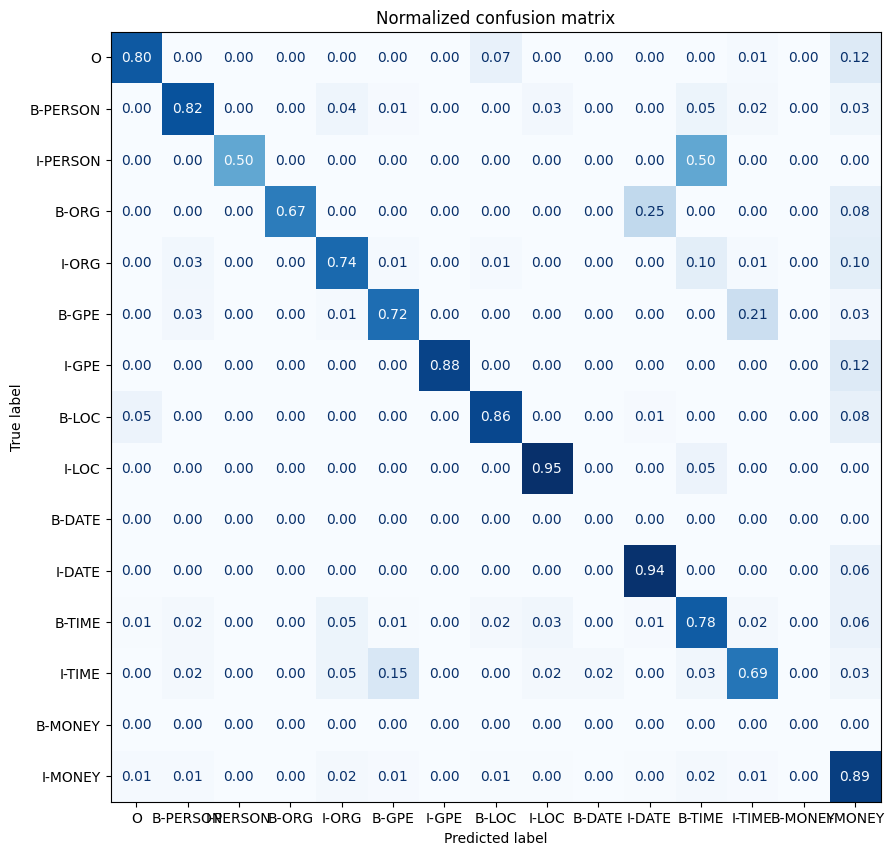

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(
    y_preds: np.ndarray, y_true: np.ndarray, labels: list[str]
) -> None:
    """
    Plot a normalized confusion matrix.

    Parameters
    ----------
    y_preds : np.ndarray
        Predicted labels, of shape (n_samples,).
    y_true : np.ndarray
        True labels, of shape (n_samples,).
    labels : list[str]
        List of label names.

    Returns
    -------
    None
        This function doesn't return anything. It displays the plot.
    """
    cm: np.ndarray = confusion_matrix(y_true, y_preds, normalize="true")
    _, ax = plt.subplots(figsize=(10, 10))
    disp: ConfusionMatrixDisplay = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=labels
    )
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


# The plot shows the model often confuses B-ORG and I-ORG entities, but performs
# well with other entities, as indicated by the near-diagonal confusion matrix
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

#### Comment
- Now that we've examined token-level errors, let's analyze sequences with high losses by summing token losses in the unexploded DataFrame and displaying them with labels.

In [55]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, _ in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp: pd.DataFrame = pd.DataFrame(
            {"tokens": tokens, "labels": labels, "preds": preds, "losses": losses}
        ).T
        yield df_tmp


df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
tokens,A,##vio,##ns,Marcel,Das,##sa,##ult,-,B,##re,##gue,##t,Aviation,S,.,A,.,said,group,profit,before,taxes,and,contributions,to,employee,profit,-,sharing,so,##ared,97,%,to,83,##9,million,f,##ran,##cs,-,L,##RB,-,$,129,.,6,million,-,R,##RB,-,in,the,first,half,of,1989,from,425,million,f,##ran,##cs,a,year,earlier,.,[SEP]
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,IGN,IGN,I-ORG,I-ORG,IGN,IGN,IGN,I-ORG,I-ORG,IGN,IGN,IGN,O,O,O,O,O,O,O,O,O,O,O,O,O,IGN,O,O,O,B-MONEY,IGN,I-MONEY,I-MONEY,IGN,IGN,O,IGN,IGN,IGN,B-MONEY,I-MONEY,IGN,IGN,I-MONEY,O,IGN,IGN,IGN,O,B-DATE,I-DATE,I-DATE,I-DATE,I-DATE,O,B-MONEY,I-MONEY,I-MONEY,IGN,IGN,B-DATE,I-DATE,I-DATE,O,IGN
preds,O,O,O,I-ORG,I-ORG,I-ORG,I-ORG,O,B-ORG,O,O,I-ORG,O,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,I-MONEY,O,I-DATE,O,O,O,O,O,B-MONEY,O,O,B-DATE,I-MONEY,O,B-PERSON,I-ORG,O,O,O,O,I-DATE,O,I-DATE,O,O,I-MONEY,O,O,O,O,I-DATE,I-DATE,O,I-DATE
losses,1.87,0.00,0.00,0.41,0.33,0.00,0.00,2.19,1.35,0.00,0.00,0.00,1.53,0.81,0.00,0.00,0.00,0.00,0.01,0.02,0.27,0.02,0.05,0.10,0.00,0.01,0.01,0.34,0.24,0.02,0.00,1.21,0.01,0.00,3.00,0.00,0.06,3.56,0.00,0.00,0.36,0.00,0.00,0.00,0.17,3.15,0.00,0.00,0.08,0.51,0.00,0.00,0.00,0.00,1.57,0.92,0.17,3.33,1.28,0.01,4.62,0.03,6.30,0.00,0.00,1.93,0.02,0.24,0.01,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
tokens,Apple,Computer,Inc,.,said,it,will,offer,cash,re,##bate,##s,on,several,of,its,machines,from,Oct,.,14,to,Dec,.,31,.,",",as,part,of,a,holiday,-,season,sales,promotion,.,[SEP]
labels,B-ORG,I-ORG,I-ORG,IGN,O,O,O,O,O,O,IGN,IGN,O,O,O,O,O,B-DATE,I-DATE,IGN,I-DATE,I-DATE,I-DATE,IGN,I-DATE,IGN,O,O,O,O,O,O,O,O,O,O,O,IGN
preds,B-ORG,I-ORG,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,I-ORG,O,O,O,B-ORG,O,I-ORG,O,O,O,O,O,O,O,O,O,O,I-ORG,O,I-ORG
losses,0.03,0.04,0.00,0.00,0.00,0.00,0.01,0.22,0.25,0.10,0.00,0.00,0.02,1.07,0.41,0.01,0.12,7.85,4.81,0.00,2.56,10.51,4.89,0.00,2.20,0.00,0.00,0.07,0.03,0.16,0.05,0.08,0.26,0.46,0.06,1.66,0.03,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
tokens,It,all,seemed,innocent,enough,:,Last,April,",",one,Steven,B,.,I,##ken,visited,Justin,Products,Inc,.,here,",",identified,himself,as,a,potential,customer,and,got,the,word,on,the,little,company,',s,new,cassette,players,for,children,.,[SEP]
labels,O,O,O,O,O,O,B-DATE,I-DATE,O,O,B-PERSON,I-PERSON,IGN,I-PERSON,IGN,O,B-ORG,I-ORG,I-ORG,IGN,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,IGN,O,O,O,O,O,O,IGN
preds,O,O,O,O,O,O,O,B-DATE,O,O,O,B-ORG,O,O,I-ORG,O,O,I-ORG,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.04,0.14,0.03,0.82,0.47,0.02,7.53,6.86,0.00,0.05,6.44,3.19,0.00,6.87,0.00,0.10,2.76,0.81,0.01,0.00,0.07,0.00,0.06,0.06,0.02,0.06,0.02,0.02,0.08,0.05,0.21,0.06,0.00,0.49,0.07,0.01,0.30,0.00,0.02,0.07,0.03,0.00,0.16,0.00,0.00
